In [41]:
#Librerias básicas
#================================================================================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import duckdb
import glob

# Configuración para las series
# ================================================================================
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
import statsmodels.api as sm

# Configuración para machine learning
# ================================================================================
import tensorflow as tf
import tensorflow.keras as keras
from pandas.core.frame import DataFrame
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import multiprocessing

# Activar SQL en Python
# ================================================================================
con = duckdb.connect(database=':memory:')

In [24]:
#Urls Pater
url_lcc = "/home/pater/Desktop/CosasPater/UNAL/2023-02NovenoSemestre/Exoplanet_IA/Curvas_de_luz_cor/"
url    = "/home/pater/Desktop/CosasPater/UNAL/2023-02NovenoSemestre/Exoplanet_IA/"

In [ ]:
#Url Ari 
url_lcc = "C:/Users/ASUS/OneDrive/Documentos/2023-2/Inteligencia/Proyecto/Exoplanet_IA/Curvas_de_luz_cor/"
url    = "C:/Users/ASUS/OneDrive/Documentos/2023-2/Inteligencia/Proyecto/Exoplanet_IA/"

In [113]:
Carac_Stars = pd.read_csv(url+"Carac_Stars.csv")
Carac_Stars

,Kepler_ID,Metalicidad,Clasificacion,incert_clas
0,10797460,0.136,CANDIDATE,1.000
1,10811496,-0.127,FALSE POSITIVE,0.000
2,10848459,-0.522,FALSE POSITIVE,0.000
3,10854555,0.081,CANDIDATE,1.000
4,10872983,-0.067,CANDIDATE,0.992
...,...,...,...,...
7677,10128825,-0.046,CANDIDATE,0.497
7678,10147276,-0.038,FALSE POSITIVE,0.021
7679,10156110,0.082,FALSE POSITIVE,0.000
7680,8460634,-0.556,FALSE POSITIVE,0.000


In [139]:
arch = os.listdir(url_lcc) 
arch.sort()
Stars_list = [star[3:-4] for star in arch]

s_flux  = []
s_err   = []
Id_real = []
for Str in arch:
    serie = pd.read_csv(url_lcc+Str).set_index('time')
    if len(serie) == 1285:
        s_flux.append(np.array(serie['flux']))
        s_err.append(np.array(serie['flux_err']))
        Id_real.append(Str[3:-4])
    else:
        continue


In [140]:
Stars = pd.DataFrame()
Stars["ID"] = Id_real
Stars

,ID
0,10000162
1,10000941
2,10001368
3,10002049
4,10002266
...,...
7201,9993683
7202,9994381
7203,9995402
7204,9995771


In [161]:
Clas_Stars = con.execute("""select S.ID, case when C.Clasificacion == 'CANDIDATE' then 1 
                                              else 0             
                                         end as ClasBin
                            from Carac_Stars C inner join Stars S on (S.ID = C.Kepler_ID)
                            order by S.ID""").df()
Clas_Stars

,ID,ClasBin
0,10000162,1
1,10000941,1
2,10001368,1
3,10002049,1
4,10002266,0
...,...,...
7201,9993683,1
7202,9994381,1
7203,9995402,1
7204,9995771,1


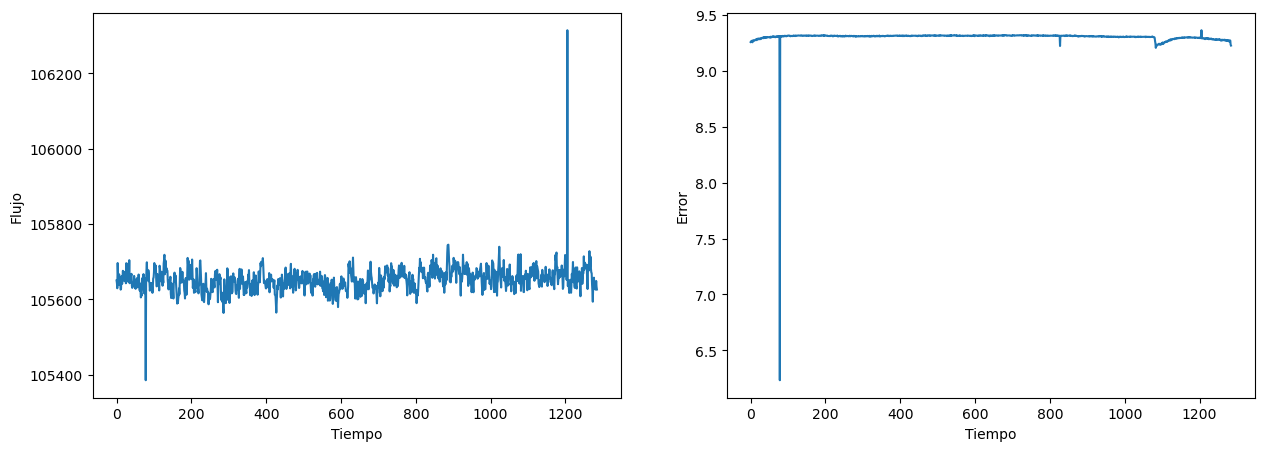

In [143]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(s_flux[198])
#plt.title(f'Curva de luz de la estrella {Stars[190]}') 
plt.ylabel('Flujo')
plt.xlabel('Tiempo')

plt.subplot(1,2,2)

plt.plot(s_err[198])
#plt.title(f'Error de la curva de luz de la estrella {Stars[190]}') 
plt.ylabel('Error')
plt.xlabel('Tiempo')

plt.show()

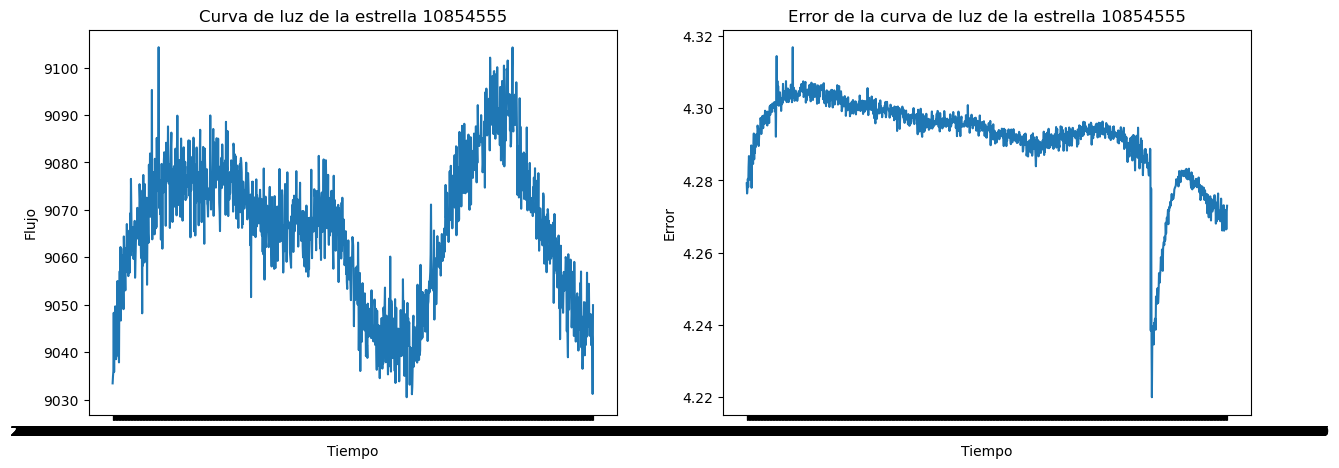

In [12]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(s_flux[6481])
plt.title(f'Curva de luz de la estrella {Stars[6481]}') 
plt.ylabel('Flujo')
plt.xlabel('Tiempo')

plt.subplot(1,2,2)

plt.plot(s_err[6481])
plt.title(f'Error de la curva de luz de la estrella {Stars[6481]}') 
plt.ylabel('Error')
plt.xlabel('Tiempo')

plt.show()

## Red Convolucional (CNN)

In [177]:
X_train, X_test, y_train, y_test = train_test_split(np.array(s_flux), 
                                                    np.array(Clas_Stars["ClasBin"]),
                                                    test_size=0.3)

X_val,  X_test,  y_val,  y_test  = train_test_split(X_test, 
                                                    y_test,
                                                    test_size=0.333)
for i in range(len(X_train)):
    mean_i = np.mean(X_train[i])
    std_i  = np.std(X_train[i])
    X_train[i] = (X_train[i] - mean_i)/std_i
    
for i in range(len(X_val)):
    mean_i = np.mean(X_val[i])
    std_i  = np.std(X_val[i])
    X_val[i] = (X_val[i] - mean_i)/std_i

X_train = X_train.reshape((len(X_train), 1285, 1))
X_test  = X_test.reshape((len(X_test), 1285, 1))
X_val   = X_val.reshape((len(X_val), 1285, 1))

print("Tamaño de entrenamiento:",X_train.shape,
      "\nTamaño de validacion:",X_val.shape,
      "\nTamaño de prueba:", X_test.shape,
      "\nDatos totales:",len(X_train)+len(X_val)+len(X_test))

Tamaño de entrenamiento: (5044, 1285, 1) 
Tamaño de validacion: (1442, 1285, 1) 
Tamaño de prueba: (720, 1285, 1) 
Datos totales: 7206


In [165]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=10, activation='relu', input_shape=(1285,1)),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

In [153]:
#CallBack para detener entrenamiento
class MNIST_Callback(tf.keras.callbacks.Callback):
    
    # método dentro de la clase myCallback, heredada de la clase Callback de keras
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.985):
            print("\nSe alcanzó un 98.5% de precisión en la validación! Cancelando Entrenamiento...")
            self.model.stop_training = True

# crea una instancia de clase
accu_callback = MNIST_Callback()

In [173]:
#Compilador del modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [178]:
history = model.fit(X_train, y_train, 
                    epochs=20, 
                    validation_data = (X_val,y_val),
                    batch_size=64,
                    callbacks=[accu_callback])

Epoch 1/20
79/79 [==============================] - 19s 235ms/step - loss: nan - accuracy: 0.5799 - val_loss: nan - val_accuracy: 0.5631
Epoch 2/20
79/79 [==============================] - 11s 143ms/step - loss: nan - accuracy: 0.5799 - val_loss: nan - val_accuracy: 0.5631
Epoch 3/20
79/79 [==============================] - 11s 135ms/step - loss: nan - accuracy: 0.5799 - val_loss: nan - val_accuracy: 0.5631
Epoch 4/20
79/79 [==============================] - 10s 130ms/step - loss: nan - accuracy: 0.5799 - val_loss: nan - val_accuracy: 0.5631
Epoch 5/20
79/79 [==============================] - 11s 137ms/step - loss: nan - accuracy: 0.5799 - val_loss: nan - val_accuracy: 0.5631
Epoch 6/20
79/79 [==============================] - 10s 133ms/step - loss: nan - accuracy: 0.5799 - val_loss: nan - val_accuracy: 0.5631
Epoch 7/20
49/79 [=================>............] - ETA: 4s - loss: nan - accuracy: 0.5762

KeyboardInterrupt: 